## Estimating and Explaining Classifier Uncertainty

This notebook provides a basic example of how to use the repository to integrate an uncertainty estimator into a typical ML pipeline and use it to estimate and explain the uncertainty that accompanies a prediction by a model.

**Read in Clinical Dataset**

In this example we will work with a dataset containing 590 urine samples (183 control samples, 208 benign hepatobiliary disease samples [of which 119 were chronic pancreatitis], and 199 PDAC samples [102 stage I–II and 97 stage III–IV]).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/Pancreatic_Cancer_Processed.csv')
df.head()

,Target,Age,Sex,Plasma_CA19_9,Creatinine,LYVE1,REG1B,TFF1,REG1A
0,0,0.111111,1.0,0.000377,0.437326,0.037383,0.037715,0.049030,0.095606
1,0,0.873016,1.0,0.000855,0.225627,0.085284,0.067288,0.015698,0.017304
2,0,0.396825,0.0,0.000226,0.178273,0.006089,0.072915,0.034557,0.015798
3,0,0.555556,0.0,0.000258,0.158774,0.000112,0.043150,0.010712,0.015798
4,0,0.571429,0.0,0.000290,0.038997,0.000031,0.046684,0.003079,0.015798


In [4]:
# Make X and y, splitting into training and testing folds
X = df.drop(columns=['Target']).to_numpy()
y = df['Target'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Define our model**

For the purposes of this example we will work with an XGBoost model.

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [6]:
# Fit model and uncertainty estimator to the data
clf = XGBClassifier()

params = {
    'n_estimators': (5, 20),
    'max_depth': (2, 15),
    'learning_rate': (0.05, 0.20),
    'min_child_weight': (1, 4)
}

model = RandomizedSearchCV(estimator=clf, 
                          param_distributions=params,
                          n_iter=10, 
                          scoring='roc_auc_ovr', 
                          cv=3, 
                          random_state=0)

**Create a knowledge base**

The knowledge base is used to help inform the estimation of misclassification risk by quantifying the performance of a model of other datasets. We will work with 3 synthetic datasets to achieve this.

In [7]:
from AITIA.heuristics import HeursiticsCalculator
from sklearn.model_selection import StratifiedKFold

In [9]:
synthetic_datasets = ['synthetic_dataset_0.csv', 'synthetic_dataset_1.csv', 'synthetic_dataset_2.csv']

for dataset in synthetic_datasets:
    df = pd.read_csv(f'data/{dataset}')
    X_ = df.drop(columns=['Target']).to_numpy()
    y_ = df['Target'].to_numpy()

    heuristics = np.array([]).reshape(0, 7)
    misclassifications = []

    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X_, y_):
        X_train_, X_test_ = X_[train_index], X_[test_index]
        y_train_, y_test_ = y_[train_index], y_[test_index]

        hc = HeursiticsCalculator(kneighbors_n=20, max_depth=5, balanced=True, rdos_neighbors=10)

        hc.fit(X_train_, y_train_)
        heuristics_ = hc.calculate(X_test_)

        model.fit(X_train_, y_train_)
        y_pred = model.predict(X_test_)
        misclassifications_ = (y_pred != y_test_)*1

        heuristics = np.append(heuristics, heuristics_, axis=0)
        misclassifications = np.append(misclassifications, misclassifications_, axis=0)

knowledge_base = {'heuristics': heuristics,
                  'misclassifications': misclassifications}

**Fit the model and uncertainty estimator to the training set and evaluate using the test set**

In [ ]:
from AITIA.uncertainty_system import UncertaintyEstimator
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [18]:
# Fit model and uncertainty estimator to the data
uncertainty_estimator = UncertaintyEstimator(model, 
                                             kneighbors_n=10, 
                                             max_depth=4, 
                                             rdos_neighbors=10, 
                                             balanced=True, 
                                             categorical_idx=[1], 
                                             knowledge_base=knowledge_base)
uncertainty_estimator.fit(X_train, y_train)

# Predict on testing set
y_pred, y_prob, uncertainty_est = uncertainty_estimator.predict(X_test, return_predictions=True)
misclassifications = (y_pred != y_test)*1

# Print performance metrics
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_prob, multi_class='ovr')
uncertainty_est_auroc = roc_auc_score(misclassifications, uncertainty_est)

print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print(f"Uncertainty Estimation AUROC: {uncertainty_est_auroc:.2f}")

Balanced Accuracy: 0.74
AUROC: 0.90
Uncertainty Estimation AUROC: 0.71


**Explain the uncertainty level**

In [19]:
from interrogation_analysis import UncertaintyExplainer

Lets plot a force plot showing what is caused the most complex patient, to be complex.

*Juding by the force plot, there is a greater than average chance the patient will be misclassified. The patient was considered challenging primarily due to there being a high degree of diversity of class labels among similar patients based on a subset of the features, with the outlierness of a patient playing a small role in increasing the uncertainty.*

Explaining Instances: 100%|██████████| 1/1 [00:02<00:00,  2.08s/instance]


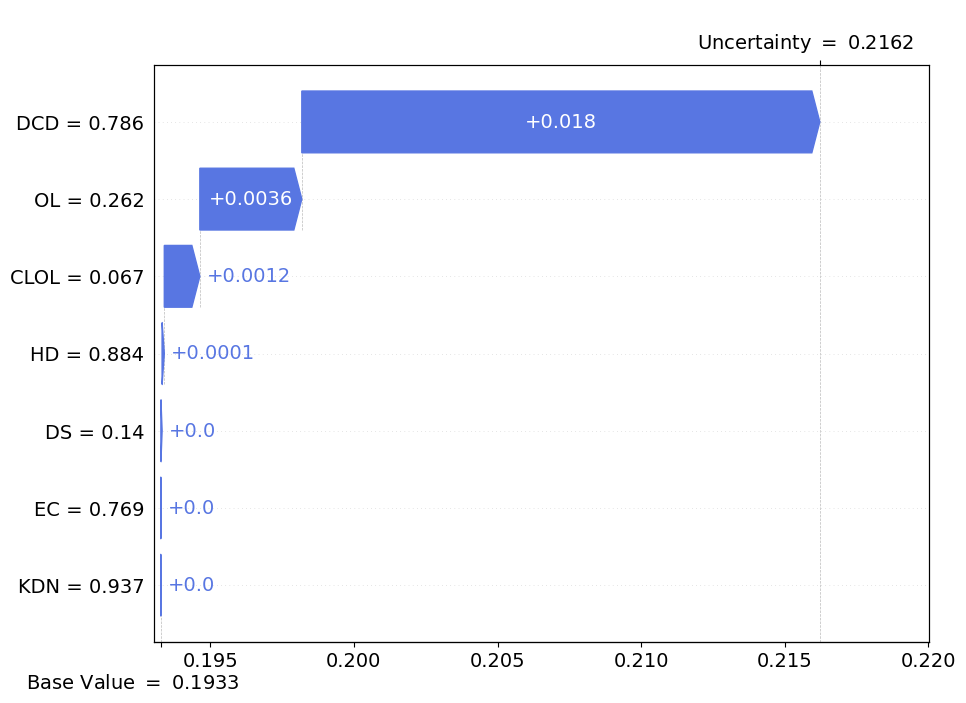

In [20]:
uncertainty_explainer = UncertaintyExplainer(uncertainty_estimator, M=1000)
uncertainty_explainer.explain(X_train, X_test[[np.argmax(uncertainty_est)]])

And now the easiest patient in the test set.

*Juding by the force plot, there is a less than average chance the patient will be misclassified. The patient was not considered almost exclusively due to there being a low degree of diversity of class labels among similar patients based on a subset of the features, with minimal to no involvment of other complexity sources.*

Explaining Instances:   0%|          | 0/1 [00:00<?, ?instance/s]

Explaining Instances: 100%|██████████| 1/1 [00:02<00:00,  2.02s/instance]


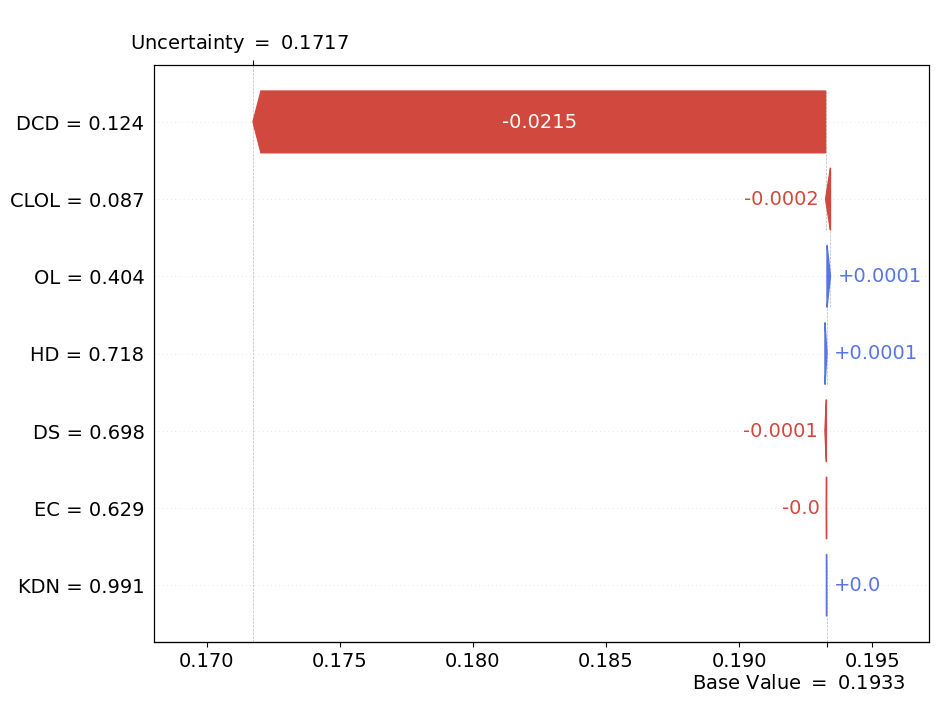

In [21]:
uncertainty_explainer.explain(X_train, X_test[[np.argmin(uncertainty_est)]])